In [46]:
import numpy as np
import scipy
from scipy.fft import fft, fftshift
import glob
import os
import zipfile
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter


# defines the frequency axis
sampling_rate = 2.2  # sample rate in MHz
num_samples = 2048  # number of samples
freqs = np.fft.fftshift(np.fft.fftfreq(num_samples, 1/sampling_rate))
freqs = freqs + 145.2



In [47]:
def check_and_load_files(directory):
    valid_files = []
    bad_files = []
    
    # lists all .npz files in the directory
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npz')]
    
    for file in files:
        try:
            # attempts to load the file to check if it's corrupted
            with np.load(file) as data:
                valid_files.append(file)
                #print(data.shape)
        except zipfile.BadZipFile:
            print(f'Bad file: {file}')
            bad_files.append(file)
        except Exception as e:
            print(f'Error in file {file}: {e}')
            bad_files.append(file)
    
    # removes bad files
    for bad_file in bad_files:
        try:
            print()
        except OSError as e:
            print(f'Error removing file {bad_file}: {e}')
    
    return valid_files

def concatenate_valid_files(valid_files):
    all_data = []
    for file in valid_files:
        try:
            # loads and append data from each valid file
            data = np.load(file)['data']
            all_data.append(data)
        except Exception as e:
            print(f'Failed to load data from {file}: {e}')
    
    # concatenates all successfully loaded data
    if all_data:
        return np.concatenate(all_data, axis=0).view('int8')
    else:
        return None


In [48]:
# Initialize three separate lists
ip_data1 = []
ip_data2 = []
ip_data3 = []

# List of IP addresses
ip_addresses = ["10.10.10.50", "10.10.10.60", "10.10.10.70"]

# List of lists to map each IP address to its corresponding list
ip_data_lists = [ip_data1, ip_data2, ip_data3]

for idx, ip in enumerate(ip_addresses):
    # Directory containing the .npz files for the current IP address
    directory = f'output_{ip}'
    
    # Get valid files from the directory
    valid_files = check_and_load_files(directory)
    
    # Append the list of valid files to the corresponding list
    ip_data_lists[idx].extend(valid_files)

# Print the results to verify
#print("ip_data_1:", ip_data_1)
#print("ip_data_2:", ip_data_2)
#print("ip_data_3:", ip_data_3)
print(ip_data_lists[0])
print(ip_data_lists[1])
print(ip_data_lists[2])

# concatenates valid files
if ip_data1:
    data1 = concatenate_valid_files(np.array(ip_data1))
    data2 = concatenate_valid_files(np.array(ip_data2))
    data3 = concatenate_valid_files(np.array(ip_data3))
    if data1 is not None:
        #data_shape = data.shape
        print()
        #print(f'Number of files:  {num_files}')
        print(f'Data shape [{ip_addresses[0]}]:       {data1.shape}')
        print(f'Data shape [{ip_addresses[1]}]:       {data2.shape}')
        print(f'Data shape [{ip_addresses[2]}]:       {data3.shape}')
        print()
else:
    print()
    print('Missing valid files.')
    print()


['output_10.10.10.50/data_00003.npz', 'output_10.10.10.50/data_00006.npz', 'output_10.10.10.50/data_00015.npz', 'output_10.10.10.50/data_00010.npz', 'output_10.10.10.50/data_00013.npz', 'output_10.10.10.50/data_00024.npz', 'output_10.10.10.50/data_00008.npz', 'output_10.10.10.50/data_00004.npz', 'output_10.10.10.50/data_00044.npz', 'output_10.10.10.50/data_00002.npz', 'output_10.10.10.50/data_00022.npz', 'output_10.10.10.50/data_00027.npz', 'output_10.10.10.50/data_00048.npz', 'output_10.10.10.50/data_00021.npz', 'output_10.10.10.50/data_00043.npz', 'output_10.10.10.50/data_00009.npz', 'output_10.10.10.50/data_00037.npz', 'output_10.10.10.50/data_00031.npz', 'output_10.10.10.50/data_00012.npz', 'output_10.10.10.50/data_00032.npz', 'output_10.10.10.50/data_00056.npz', 'output_10.10.10.50/data_00040.npz', 'output_10.10.10.50/data_00005.npz', 'output_10.10.10.50/data_00051.npz', 'output_10.10.10.50/data_00025.npz', 'output_10.10.10.50/data_00001.npz', 'output_10.10.10.50/data_00042.npz', 

In [49]:
# converts to complex data
data_comp1 = data1[...,0] + 1j * data1[...,1]
data_comp2 = data2[...,0] + 1j * data2[...,1]
data_comp3 = data3[...,0] + 1j * data3[...,1]

# computes power spectra for plotting
def perform_power(signal):
    return np.abs(signal)**2

# fft shifts the signal data
def shift(signal):
    return fftshift(signal)


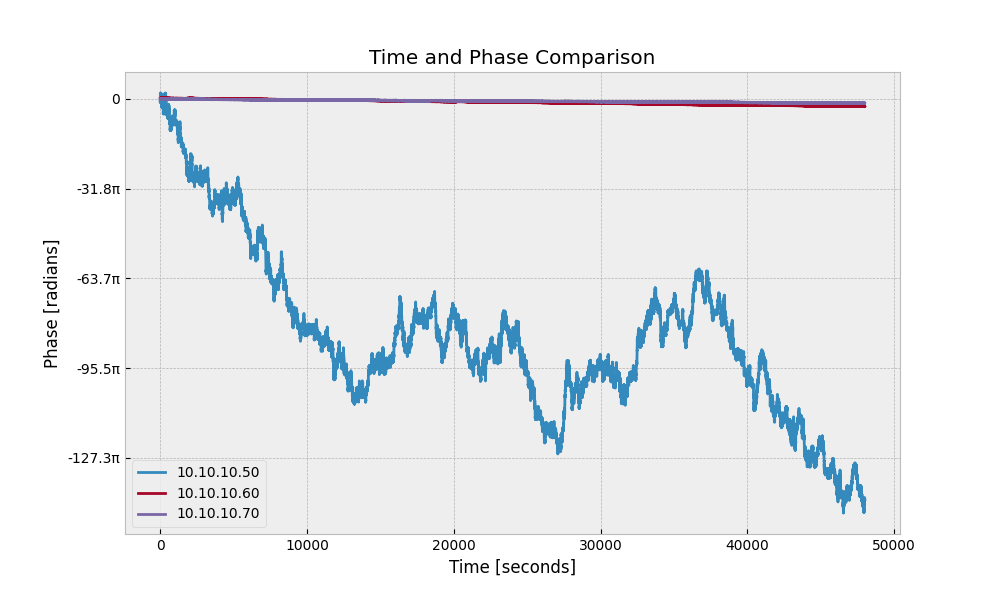

In [50]:
# creates the function to format the y-axis in terms of multiples of pi
def radian_formatter(x, pos):
    return f'{x/np.pi:.1f}π' if x != 0 else '0'

# parameters
offset = 0
time_num = 4*12000

t = np.arange(time_num) * 1/2.2e6
phazor = np.exp(2*np.pi*1j * 0.2e6 * t)

# creates a list of datasets and labels for IP addresses
data_comps = [data_comp1, data_comp2, data_comp3]
labels = ip_addresses

plt.style.use('bmh')
plt.figure(figsize=(10,6))
plt.title('Time and Phase Comparison')

# plots each dataset with the corresponding IP label
for data_comp, label in zip(data_comps, labels):
    plt.plot(np.unwrap(np.angle(data_comp.ravel()[offset:offset+time_num] * phazor)), label=label)

plt.xlabel('Time [seconds]')
plt.ylabel('Phase [radians]')

# formats the y-axis ticks as multiples of π
plt.gca().yaxis.set_major_formatter(FuncFormatter(radian_formatter))

plt.legend(loc='best')
plt.show()


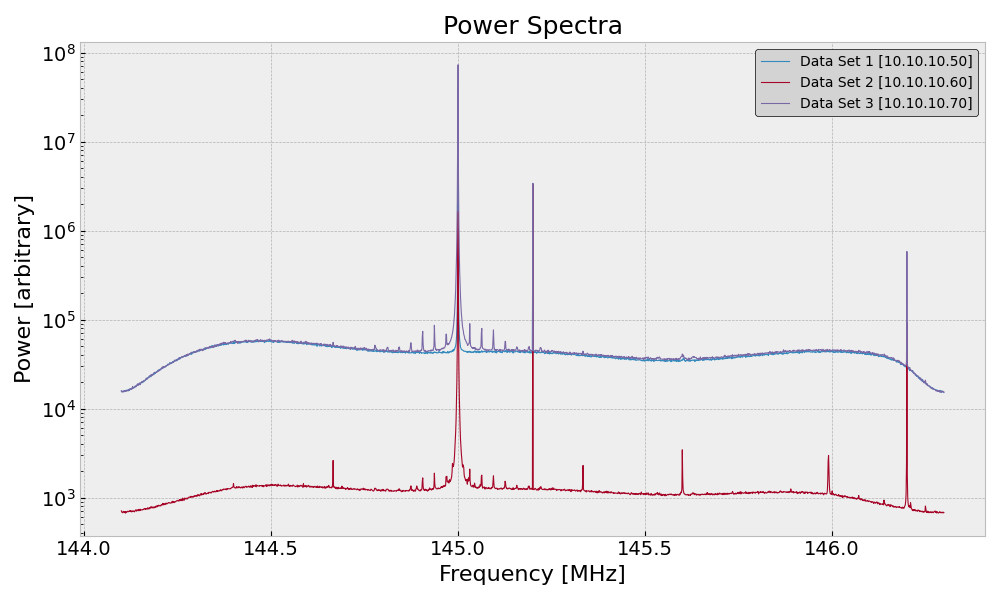

In [35]:
plt.figure(figsize=(10, 6))

# plots the power spectra
pwr_mean1 = shift(np.mean(perform_power(fft(data_comp1)), axis=0))
pwr_mean2 = shift(np.mean(perform_power(fft(data_comp2)), axis=0))
pwr_mean3 = shift(np.mean(perform_power(fft(data_comp3)), axis=0))

plt.semilogy(freqs, pwr_mean1, linewidth=0.8, label='Data Set 1 [10.10.10.50]')
plt.semilogy(freqs, pwr_mean2, linewidth=0.8, label='Data Set 2 [10.10.10.60]')
plt.semilogy(freqs, pwr_mean3, linewidth=0.8, label='Data Set 3 [10.10.10.70]')

plt.title('Power Spectra', fontsize=18)
plt.xlabel('Frequency [MHz]', fontsize=16)
plt.ylabel('Power [arbitrary]', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Limit decimal places on x-axis to one
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.tight_layout()

# adds a snazzy custom legend
plt.legend(loc='best', framealpha=1, frameon=True, facecolor='lightgray', edgecolor='k')

# shows the plot
plt.show()

In [12]:
# pwr1 = shift((perform_power(fft(data_comp1))))
# pwr2 = shift((perform_power(fft(data_comp2))))
# pwr3 = shift((perform_power(fft(data_comp3))))

# plt.semilogy(freqs, pwr1, linewidth=0.8, label='Data Set 1 [10.10.10.50]')
# plt.semilogy(freqs, pwr2, linewidth=0.8, label='Data Set 2 [10.10.10.60]')
# plt.semilogy(freqs, pwr3, linewidth=0.8, label='Data Set 3 [10.10.10.70]')

# plt.title('Power Spectra', fontsize=18)
# plt.xlabel('Frequency [MHz]', fontsize=16)
# plt.ylabel('Power [arbitrary]', fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# # Limit decimal places on x-axis to one
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# plt.tight_layout()

# # adds a snazzy custom legend
# plt.legend(loc='best', framealpha=1, frameon=True, facecolor='lightgray', edgecolor='k')

# # shows the plot
# plt.show()

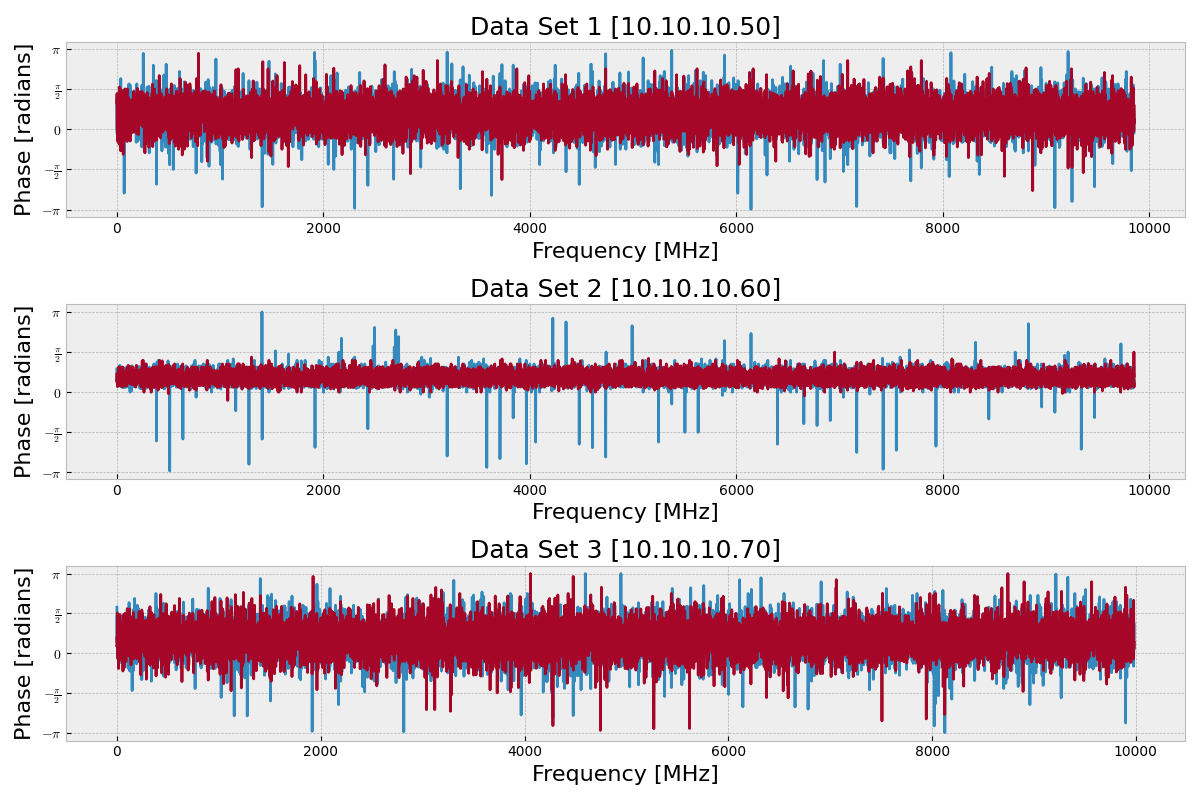

In [43]:
# creates a figure with 3 subplots
plt.figure(figsize=(12, 8))

# subplot for data_comp1
plt.subplot(3, 1, 1)
plt.plot(np.angle(data_comp1[:-1, -1] * data_comp1[1:, 0].conj()), label='Real')
plt.plot(np.angle(data_comp1[:, -2] * data_comp1[:, -1].conj()), label='Imaginary')
plt.xlabel('Frequency [MHz]', fontsize=16)
plt.ylabel('Phase [radians]', fontsize=16)
plt.title('Data Set 1 [10.10.10.50]', fontsize=18)
plt.yticks(np.linspace(-np.pi, np.pi, 5), [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.gca().ticklabel_format(axis='x', style='plain')

# subplot for data_comp2
plt.subplot(3, 1, 2)
plt.plot(np.angle(data_comp2[:-1, -1] * data_comp2[1:, 0].conj()), label='Real')
plt.plot(np.angle(data_comp2[:, -2] * data_comp2[:, -1].conj()), label='Imaginary')
plt.xlabel('Frequency [MHz]', fontsize=16)
plt.ylabel('Phase [radians]', fontsize=16)
plt.title('Data Set 2 [10.10.10.60]', fontsize=18)
plt.yticks(np.linspace(-np.pi, np.pi, 5), [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.gca().ticklabel_format(axis='x', style='plain')

# subplot for data_comp3
plt.subplot(3, 1, 3)
plt.plot(np.angle(data_comp3[:-1, -1] * data_comp3[1:, 0].conj()), label='Real')
plt.plot(np.angle(data_comp3[:, -2] * data_comp3[:, -1].conj()), label='Imaginary')
plt.xlabel('Frequency [MHz]', fontsize=16)
plt.ylabel('Phase [radians]', fontsize=16)
plt.title('Data Set 3 [10.10.10.70]', fontsize=18)
plt.yticks(np.linspace(-np.pi, np.pi, 5), [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.gca().ticklabel_format(axis='x', style='plain')

plt.tight_layout()

plt.show()


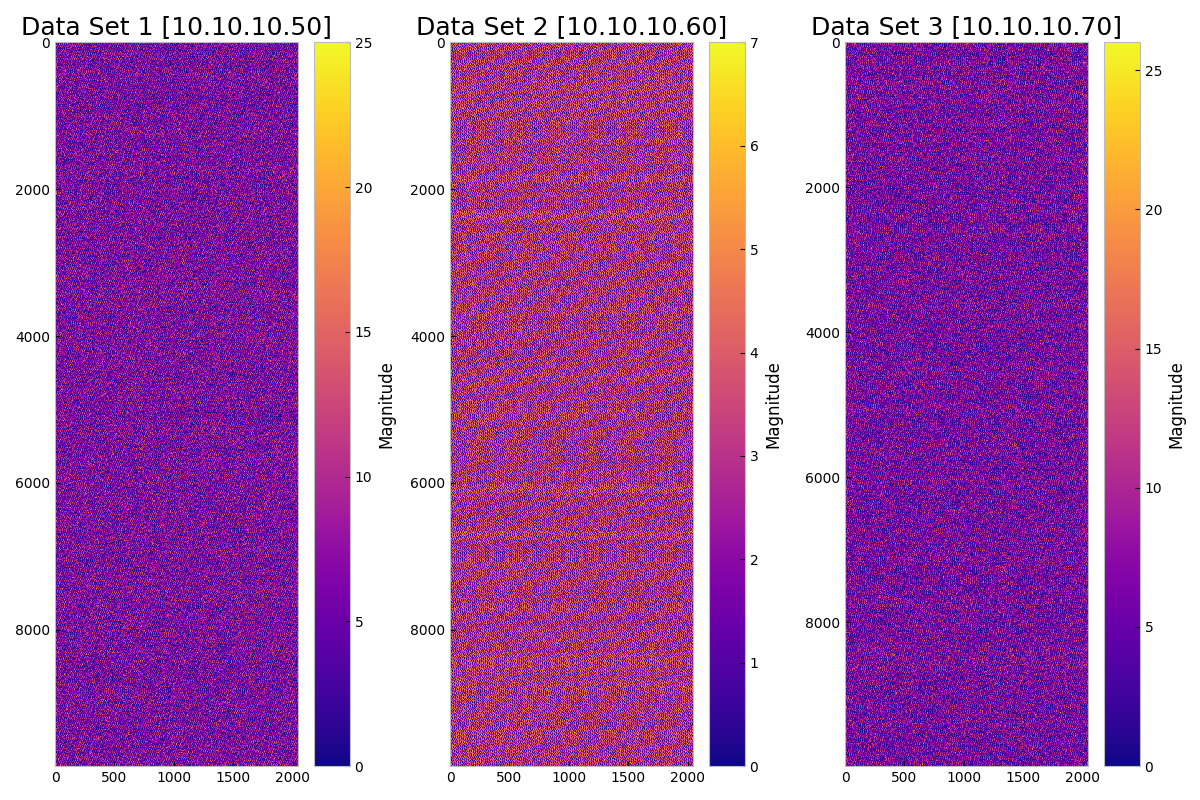

In [44]:
# creates a figure with 3 subplots for magnitude
plt.figure(figsize=(12, 8))

# subplot for data_comp1
plt.subplot(1, 3, 1)
plt.imshow(np.abs(data_comp1[:, :].real), cmap='plasma', interpolation='nearest', aspect='auto')
plt.colorbar(label='Magnitude')
plt.title('Data Set 1 [10.10.10.50]', fontsize=18)
plt.grid(False)

# subplot for data_comp2
plt.subplot(1, 3, 2)
plt.imshow(np.abs(data_comp2[:, :].real), cmap='plasma', interpolation='nearest', aspect='auto')
plt.colorbar(label='Magnitude')
plt.title('Data Set 2 [10.10.10.60]', fontsize=18)
plt.grid(False)

# subplot for data_comp3
plt.subplot(1, 3, 3)
plt.imshow(np.abs(data_comp3[:, :].real), cmap='plasma', interpolation='nearest', aspect='auto')
plt.colorbar(label='Magnitude')
plt.title('Data Set 3 [10.10.10.70]', fontsize=18)
plt.grid(False)

plt.tight_layout()
plt.show()

In [45]:
print(np.shape(data_comp1))

(9856, 2048)


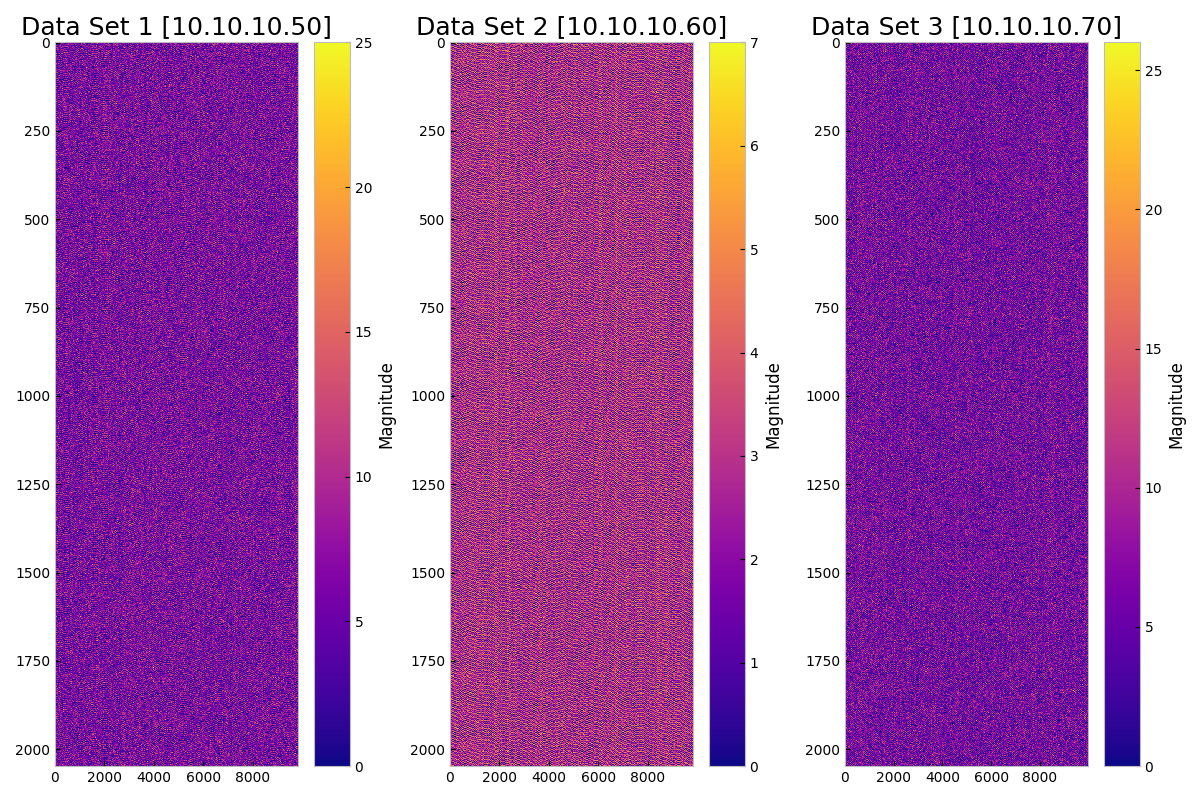

In [46]:
'''This is the transpose of the data plotted (switching x- and y-axes)'''

# creates a figure with 3 subplots for magnitude
plt.figure(figsize=(12, 8))

# subplot for data_comp1
plt.subplot(1, 3, 1)
plt.imshow(np.abs(data_comp1[:, :].real).T, cmap='plasma', interpolation='nearest', aspect='auto')
plt.colorbar(label='Magnitude')
plt.title('Data Set 1 [10.10.10.50]', fontsize=18)
plt.grid(False)

# subplot for data_comp2
plt.subplot(1, 3, 2)
plt.imshow(np.abs(data_comp2[:, :].real).T, cmap='plasma', interpolation='nearest', aspect='auto')
plt.colorbar(label='Magnitude')
plt.title('Data Set 2 [10.10.10.60]', fontsize=18)
plt.grid(False)

# subplot for data_comp3
plt.subplot(1, 3, 3)
plt.imshow(np.abs(data_comp3[:, :].real).T, cmap='plasma', interpolation='nearest', aspect='auto')
plt.colorbar(label='Magnitude')
plt.title('Data Set 3 [10.10.10.70]', fontsize=18)
plt.grid(False)

plt.tight_layout()
plt.show()

Shape of cross_corr_2d: (6353, 6354)


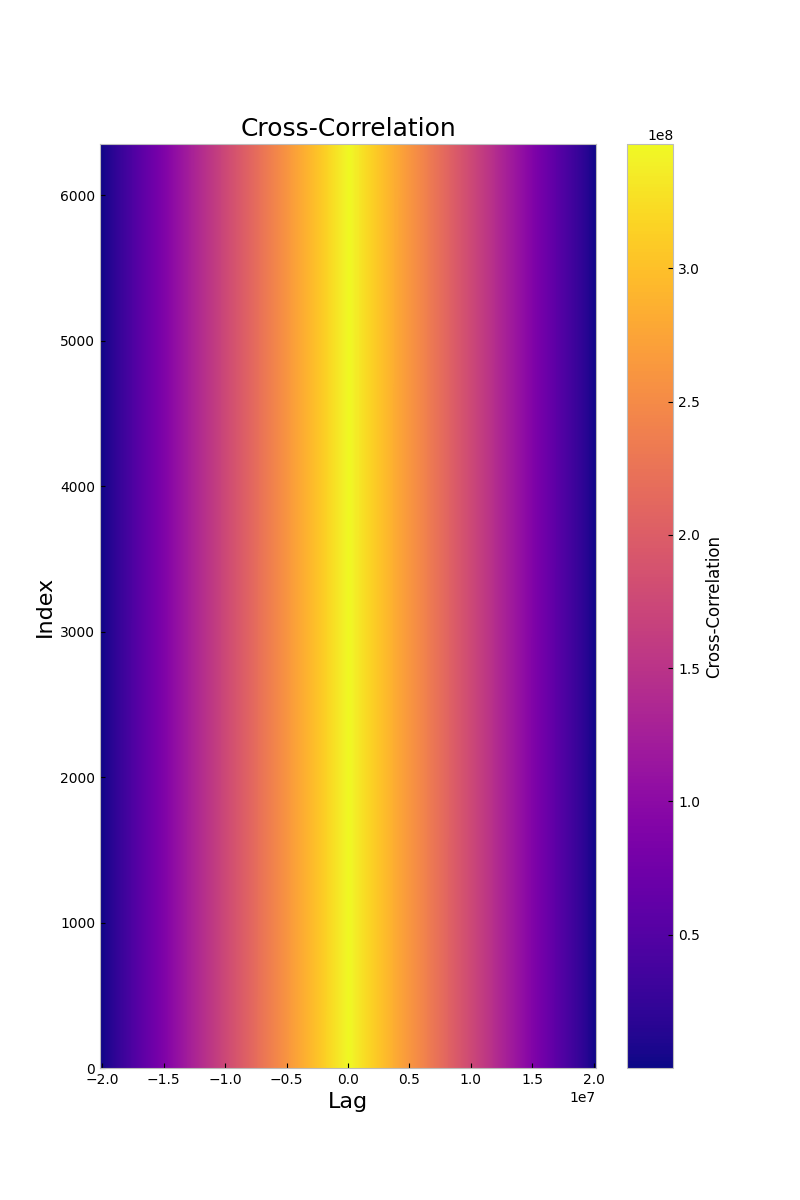

In [49]:
from scipy.signal import correlate

# Assuming data_comp1 and data_comp2 are defined and contain your data
data_comp1_new = np.abs(data_comp1[:, :].real) 
data_comp2_new = np.abs(data_comp2[:, :].real)

# Compute the cross-correlation
cross_corr = correlate(data_comp1_new.flatten(), data_comp2_new.flatten(), mode='full')

# Calculate the length of the cross-correlation and lags array
n = len(data_comp1_new.flatten())
lags = np.arange(-n + 1, n)

# Reshape the cross-correlation result to 2D for imshow
# Ensure the length of cross_corr fits into the 2D shape
width = int(np.sqrt(len(cross_corr)))
height = len(cross_corr) // width

# Reshape and pad if necessary to fit into the desired shape
cross_corr_2d = np.reshape(cross_corr[:width*height], (height, width)).T

# Verify the shape
print(f'Shape of cross_corr_2d: {cross_corr_2d.shape}')

# Plot the reshaped cross-correlation result
plt.figure(figsize=(8, 12))
plt.imshow(cross_corr_2d, aspect='auto', cmap='plasma', extent=[lags.min(), lags.max(), 0, cross_corr_2d.shape[0]])
plt.colorbar(label='Cross-Correlation')
plt.xlabel('Lag', fontsize=16)
plt.ylabel('Index', fontsize=16)
plt.title('Cross-Correlation', fontsize=18)
plt.grid(False)

plt.show()


In [35]:
# # Example list of directories or paths
# directories = ['output_10.10.10.50', 'output_10.10.10.60', 'output_10.10.10.70']

# # Initialize an empty list to store data from all directories
# all_data = []

# # Function to load valid files and append the data to the list
# def load_data_from_directories(directories):
#     for directory in directories:
#         # Check if the directory exists and is a directory
#         if os.path.isdir(directory):
#             # List all .npz files in the directory
#             files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npz')]
            
#             # Load the data from each valid file
#             for file in files:
#                 try:
#                     with np.load(file) as data:
#                         # Assuming 'data' is the key in the .npz file
#                         all_data.append(data['data'])
#                 except Exception as e:
#                     print(f"Error loading {file}: {e}")
#         else:
#             print(f"Not a directory: {directory}")

# # Load the data
# load_data_from_directories(directories)

# # Concatenate all loaded data into one array
# if all_data:
#     concatenated_data = np.concatenate(all_data, axis=0)
#     print(f"Concatenated data shape: {concatenated_data.shape}")
# else:
#     print("No data to concatenate.")
